In [32]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from proj1_helpers import *
from costs import *
from lab_helpers import *
from plots_lab4 import *
from my_helpers import *
import pandas as pd
import matplotlib.pyplot as plt

## To Do Graphs
- PCA Decomposition + Classification
- Correlation
- Changing loss for different algorithms
- ???

## To Do tasks
- Manuel: implement K-fold to choose degree, change split data , ?
- Gabbo: ?
- Marco: ?

## Load the training data into feature matrix, class labels, and event ids:

In [34]:
DATA_TRAIN_PATH = '../data/train.csv'
y_or, tX_or, ids = load_csv_data(DATA_TRAIN_PATH)

In [35]:
y = y_or
tX = tX_or

## Data preprocessing

In [36]:
tX_pd = pd.DataFrame(tX)
tX_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,-0.277,258.733,2.0,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,-1.916,164.546,1.0,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,-2.186,260.414,1.0,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,0.060,86.062,0.0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,-0.871,53.131,0.0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


### Correlation graph needed

In [37]:
for i in range(0,30):
    s = tX_pd[tX_pd[i]==-999].index.size
    if s > 900:
        print(i, s)

0 38114
4 177457
5 177457
6 177457
12 177457
23 99913
24 99913
25 99913
26 177457
27 177457
28 177457


Funzione di Marco per cancellare tutto con numpy e mettere la media: da scrivere e usare al posto di pandas alla fine

In [38]:
# uno = np.where(tX==-999,1,0)
# s = np.sum(uno,axis=0)
# index = np.argwhere(s > 100000)
# new = np.delete(tX,index[1:],axis=1)
# uno = np.where(new==-999,1,0)
# s = np.sum(uno,axis=0)
# index = np.argwhere((s>40000)&(s < 100000))
# new = np.delete(new,index[1:],axis=1)
# uno = np.where(new==-999,1,0)
# s = np.sum(uno,axis=0)
# index = np.argwhere((s<40000)&(s>1))
# prima = new[:,index]
# index_ = np.argwhere(prima==-999)
# prima_new = np.delete(prima, index_)
# media = np.median(prima_new)
# prima[prima==-999] = media
# new[:,index] = prima

# uno = np.where(new==-999,1,0)
# s = np.sum(uno,axis=0)
# index = np.argwhere((s>40000)&(s < 100000))
# prima = new[:,index]
# index_ = np.argwhere(prima==-999)
# prima_new = np.delete(prima, index_)
# media = np.median(prima_new)
# prima[prima==-999] = media
# new[:,index] = prima

# uno = np.where(new==-999,1,0)
# s = np.sum(uno,axis=0)
# index = np.argwhere(s > 100000)
# prima = new[:,index]
# index_ = np.argwhere(prima==-999)
# prima_new = np.delete(prima, index_)
# media = np.median(prima_new)
# prima[prima==-999] = media
# new[:,index] = prima

Drop PRI with a lot of null + 29 (29 is a Pri corr with 9)

In [39]:
drops = [5,6,12,24,25,26,27,28,29]

In [40]:
tX_pd.drop(drops, axis=1, inplace=True)

In [41]:
#replace with median
tX_pd.where(tX_pd!=-999, inplace=True)
tX_pd.fillna(tX_pd.median(), inplace=True)

In [42]:
tX = tX_pd.values

Normalize Data

In [43]:
tX, mean_x, std_x = standardize(tX)

Split Data

In [44]:
x_tr, x_te, y_tr, y_te = split_data(y,tX,0.8,1)

In [45]:
def cross_validation(y, x, k_indices, k, lambda_, degree, mean=True):
    """return the loss of ridge regression."""
    losses_tr = []
    losses_te = []
    for k_group in range(k):
        index_te = k_indices[k_group]
        index_tr = np.setdiff1d(np.arange(len(y)), index_te)
        x_te = x[index_te,:]
        x_tr = x[index_tr,:]
        y_te = y[index_te]
        y_tr = y[index_tr]
    # ***************************************************
    # INSERT YOUR CODE HERE
    # get k'th subgroup in test, others in train: TODO
    # ***************************************************
        x_te_poly = build_poly_2(x_te, degree)
        x_tr_poly = build_poly_2(x_tr, degree)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form data with polynomial degree: TODO
    # ***************************************************
        w = ridge_regression(y_tr, x_tr_poly, lambda_)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    # ***************************************************
        rmse_tr = compute_rmse(y_tr, x_tr_poly, w)
        rmse_te = compute_rmse(y_te, x_te_poly, w)
        losses_tr.append(rmse_tr)
        losses_te.append(rmse_te)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate the loss for train and test data: TODO
    # ***************************************************
    if mean==True:
        loss_tr = np.mean(losses_tr)
        loss_te = np.mean(losses_te)
    else:
        loss_tr = losses_tr
        loss_te = losses_te
    return loss_tr, loss_te

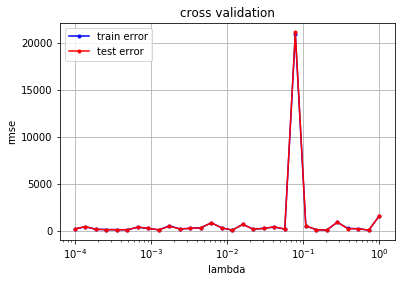

In [289]:
np.random.seed(2)
sub_size = 5000
indexes = np.arange(tX.shape[0])
np.random.shuffle(indexes)  
sub_index = indexes[:sub_size] 
x_sub = tX[sub_index,:]
y_sub = y[sub_index]


def cross_validation_demo():
    seed = 1
    degree = 6
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    #lambdas =[0.1, 0.01, 1]
    # split data in k fold
    k_indices = build_k_indices(y_sub, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    for lambda_ in lambdas:
        loss_tr, loss_te = cross_validation(y_sub, x_sub, k_indices, k_fold, lambda_, degree)
        rmse_tr.append(loss_tr)
        rmse_te.append(loss_te)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # cross validation: TODO
    # ***************************************************    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

In [46]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    w = initial_w
    loss = np.inf
    for n_iter in range(max_iters):
        g = compute_gradient(y, tx, w)
        new_w = w - gamma*g;
        new_loss = compute_loss(y, tx, new_w)
        # print TO DELETE IN FINAL VERSION
        if new_loss <= loss:
            loss, w = new_loss, new_w
            gamma *=1.8 #accelerate algorithm learning rate
            #print("Gradient Descent({bi}/{ti}): loss={l} ; gamma={g}; gamma aumenta".format(
             # bi=n_iter, ti=max_iters - 1, l=loss, g= gamma))
        else:
            gamma *=0.3 #decelerate to avoid exponential growing
            #print("Gradient Descent({bi}/{ti}): loss={l} ; gamma={g}; gamma diminuisce".format(
             # bi=n_iter, ti=max_iters - 1, l=loss, g= gamma)
        print("Gradient Descent({bi}/{ti}): ||gradient||={grad}, loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, grad=np.linalg.norm(g), l=loss, w0=w[0], w1=w[1]))

    return w, loss

In [47]:
# Define the parameters of the algorithm.
max_iters = 200
gamma = 0.0001

# Initialization
w_initial = np.zeros(tX.shape[1])

# Start gradient descent.
gradient_w, gradient_loss = gradient_descent(y, tX, w_initial, max_iters, gamma)

Gradient Descent(0/199): ||gradient||=0.9198964473372747, loss=0.49991543478685996, w0=-3.1381702249274604e-05, w1=-1.870332018899931e-05
Gradient Descent(1/199): ||gradient||=0.9186848945865361, loss=0.4997636980245322, w0=-8.78042153832626e-05, w1=-5.236507656267239e-05
Gradient Descent(2/199): ||gradient||=0.9165086790795948, loss=0.4994921215723027, w0=-0.00018915591588298592, w1=-0.00011294257728487969
Gradient Descent(3/199): ||gradient||=0.9126063083581455, loss=0.4990082616199879, w0=-0.000370914263529803, w1=-0.0002219378872869192
Gradient Descent(4/199): ||gradient||=0.9056299309807633, loss=0.49815319084166065, w0=-0.0006959041130019329, w1=-0.00041798666987893115
Gradient Descent(5/199): ||gradient||=0.8932269289430593, loss=0.49666407351067016, w0=-0.0012739014639035493, w1=-0.0007704142328603178
Gradient Descent(6/199): ||gradient||=0.8713980371643467, loss=0.49413764114400255, w0=-0.002292032255140569, w1=-0.0014033062129404496
Gradient Descent(7/199): ||gradient||=0.833

In [48]:
def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent algorithm."""
    w = initial_w
    loss = np.inf
    for n_iter in range(max_iters):
        for yn, xn in batch_iter(y, tx, batch_size):
            g = compute_stoch_gradient(yn, xn, w)
            new_w = w - gamma*g;
            new_loss = compute_loss(y, tx, new_w)
        if new_loss <= loss:
            loss , w = new_loss , new_w
            gamma *=1.8
            #print("SGD({bi}/{ti}): loss={l} ; gamma={g}; gamma aumenta".format(
             # bi=n_iter, ti=max_iters - 1, l=loss, g= gamma))
        else:
            gamma *=0.3
            #print("SGD({bi}/{ti}): loss={l} ; gamma={g}; gamma diminuisce".format(
             #     bi=n_iter, ti=max_iters - 1, l=loss, g= gamma))
        print("SGD({bi}/{ti}): |gradient|={grad}, loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, grad=np.linalg.norm(g), l=loss, w0=w[0], w1=w[1]))

    return w, loss

In [49]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 100
gamma = 0.01
batch_size = 1

# Initialization
w_initial = np.zeros(tX.shape[1])

# Start SGD.
sgd_loss, sgd_w = stochastic_gradient_descent(
    y, tX, w_initial, batch_size, max_iters, gamma)


SGD(0/99): |gradient|=3.819894318273993, loss=0.5415004344865282, w0=0.011805540261408516, w1=-0.002686097454581817
SGD(1/99): |gradient|=3.313465869115332, loss=0.5415004344865282, w0=0.011805540261408516, w1=-0.002686097454581817
SGD(2/99): |gradient|=2.7465500598415247, loss=0.5231169592050283, w0=0.006188461831573778, w1=-0.003969062074416842
SGD(3/99): |gradient|=3.2750457421264016, loss=0.49026883819335143, w0=-0.0036366473237117534, w1=-0.008645873148768043
SGD(4/99): |gradient|=3.648974628785057, loss=0.4714873513207109, w0=-0.019703815429169942, w1=-0.026240410268246465
SGD(5/99): |gradient|=3.4494660744980905, loss=0.4714873513207109, w0=-0.019703815429169942, w1=-0.026240410268246465
SGD(6/99): |gradient|=3.143628555043909, loss=0.4714873513207109, w0=-0.019703815429169942, w1=-0.026240410268246465
SGD(7/99): |gradient|=2.8915114659527927, loss=0.4714873513207109, w0=-0.019703815429169942, w1=-0.026240410268246465
SGD(8/99): |gradient|=2.897412774883511, loss=0.4714873513207

In [50]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    D = tx.shape[1]
    G = tx.T.dot(tx)
    if(np.linalg.matrix_rank(G)==D):
        w = np.linalg.inv(G).dot(tx.T).dot(y)
    else:
        w = np.linalg.lstsq(G,tx.T.dot(y), rcond=None) [0]
    return w

In [51]:
w_ls = least_squares(y, tX)
loss = compute_loss(y, tX, w_ls)
loss

0.3461418418779361

In [52]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    N = len(y)
    G = tx.T.dot(tx)
    i = np.linalg.inv(G + 2*N*lambda_*np.eye(G.shape[0]))
    w_star = i.dot(tx.T).dot(y)
    return w_star

In [53]:
lambda_ = 0.001
w = ridge_regression(y_tr, x_tr, lambda_)
loss_tr = compute_loss(y_tr, x_tr, w)
loss_te = compute_loss(y_te, x_te, w)
print(loss_tr, loss_te)

0.3705354861132588 0.371104805977637


## Generate predictions and save ouput in csv format for submission:

In [227]:
DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [246]:
OUTPUT_PATH = '../data/submission.csv'
tX_test_s, mean_tes, std_test = standardize(tX_test)
y_pred = predict_labels(weights, tX_test_s)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

array([[-2.96637287, -1.59557484],
       [-0.96443888,  2.30659937],
       [-2.7925803 , -1.26619016],
       ...,
       [-2.78555006, -1.2651345 ],
       [-0.97573941,  2.28919741],
       [-2.80136474, -1.27570913]])

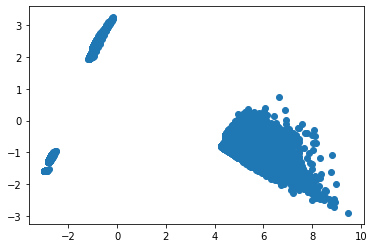

In [263]:
#we will need something like this

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(tX_test_s)
plt.scatter(principalComponents[:,0], principalComponents[:,1])